# Optuna Tutorial

## Installation

In [1]:
!pip install optuna --quiet
!pip install optuna-dashboard --quiet
!pip install jupyterlab-optuna --quiet
!pip install optuna-integration --quiet # BoTorch or Lightning or something-else.

# Dependencies
!pip install pandas --quiet
!pip install plotly --quiet

## Import

In [2]:
import optuna

# Samplers - for parameter searching
from optuna.samplers import TPESampler

# Pruners - for pruning (such as earlystopping) 
from optuna.pruners import MedianPruner

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import wandb
import numpy as np
import matplotlib.pyplot as plt
import os

/home/xteca/Documents/Project/Machine_Learning/MLStudy2024/week02/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Toy Problem

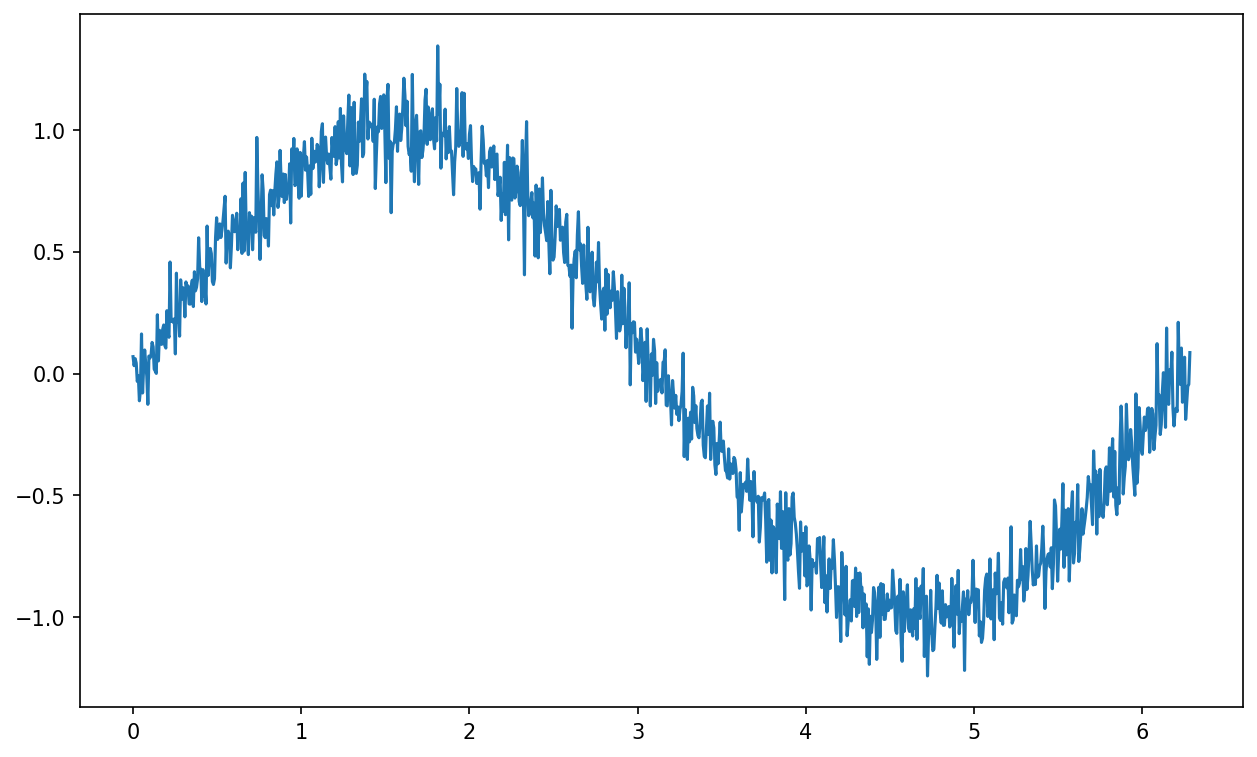

In [3]:
x = torch.linspace(0, 2*torch.pi, 1000)
y = x.sin() + torch.randn_like(x) * 0.1

plt.figure(figsize=(10,6), dpi=150)
plt.plot(x,y)
plt.show()

In [4]:
class ToyData(Dataset):
    def __init__(self, x, y):
        self.x = x.reshape(-1,1)
        self.y = y.reshape(-1,1)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [5]:
ds = ToyData(x, y)
len(ds)

1000

In [6]:
ics = torch.randperm(len(ds))
train_ics = ics[:800]
val_ics = ics[800:]

x_train = x[train_ics]
x_val   = x[val_ics]
y_train = y[train_ics]
y_val   = y[val_ics]

ds_train = ToyData(x_train, y_train)
ds_val   = ToyData(x_val, y_val)

In [7]:
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val   = DataLoader(ds_val, batch_size=64)

## Define Model

In [8]:
class ToyModel(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.num_nodes = hparams["num_nodes"]
        self.num_layers = hparams["num_layers"]
        self.lr = hparams["lr"]
        self.activation = hparams["activation"]

        activation = nn.ReLU() if self.activation == "relu" else nn.GELU()

        net = []
        net.extend([nn.Linear(1, self.num_nodes), activation])
        for _ in range(self.num_layers):
            net.extend([nn.Linear(self.num_nodes, self.num_nodes), activation])
        net.append(nn.Linear(self.num_nodes, 1))

        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

## Define train & validation process

In [9]:
def train_epoch(model, optimizer, dataloader, device):
    model.train()
    epoch_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = model(x.to(device))
        loss = F.mse_loss(y_hat, y.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    return epoch_loss

def val_epoch(model, optimizer, dataloader, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            optimizer.zero_grad()
            y_hat = model(x.to(device))
            loss = F.mse_loss(y_hat, y.to(device))
            epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    return epoch_loss

## Define objective

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial):
    hparams = {
        "num_nodes": trial.suggest_categorical("num_nodes", [8, 16, 32]),
        "num_layers": trial.suggest_categorical("num_layers", [2, 3, 4]),
        "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        "activation": trial.suggest_categorical("activation", ["relu", "gelu"])
    }

    model = ToyModel(hparams)
    model.to(device)
    optimizer = Adam(model.parameters(), lr=hparams['lr'])

    checkpoint_dir = trial.study.study_name
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # To prune
    try:
        run = wandb.init(project="Optuna-tutorial", config=hparams, reinit=False)
        for epoch in range(200):
            train_loss = train_epoch(model, optimizer, dl_train, device)
            val_loss = val_epoch(model, optimizer, dl_val, device)

            # Report to optuna for pruning
            trial.report(val_loss, epoch)
            wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch+1})

            # Prune
            if trial.should_prune():
                raise optuna.TrialPruned()
                
    except optuna.TrialPruned:
        run.finish(exit_code=255) # if pruned, finish run with error code
        raise

    trial_path = os.path.join(checkpoint_dir, f"trial_{trial.number}.pt")
    torch.save(model.state_dict(), trial_path)
    trial.set_user_attr("checkpoint", trial_path)

    run.finish()

    return val_loss

## Hyperparameter tuning via Optuna

In [11]:
sampler = TPESampler(seed=42)
pruner  = MedianPruner(n_startup_trials=10, n_warmup_steps=10, interval_steps=5)

- `n_start_up_trials` : 이만큼 쌓일 때까지는 prune 하지 말기
- `n_warmup_steps` : trial마다 처음 10번은 참자
- `interval_steps` : `n_warmup_steps` 이후에 `interval_steps` 마다 평가해서 prune

In [12]:
study = optuna.create_study(
    direction="minimize", # 'minimize' 혹은 'maximize'
    sampler=sampler,
    pruner=pruner,
    study_name="Optuna-tutorial",
    storage="sqlite:///optuna.db", # Database 경로 - postgres, sqlite 등등 원격데이터베이스도 가능
    load_if_exists=True, # Database가 이미 있을때 해당 데이터를 받아들이고 이후부터 이어서 하기
)

[I 2024-04-02 20:32:48,250] Using an existing study with name 'Optuna-tutorial' instead of creating a new one.


In [13]:
# study.optimize(objective, n_trials=50)

In [14]:
df = study.trials_dataframe()

In [15]:
df.sort_values(by="value")

,number,value,datetime_start,datetime_complete,duration,params_activation,params_lr,params_num_layers,params_num_nodes,user_attrs_checkpoint,state
10,10,0.007266,2024-04-02 20:07:45.903670,2024-04-02 20:08:00.655854,0 days 00:00:14.752184,relu,0.001884,4,8,Optuna-tutorial/trial_10.pt,COMPLETE
15,15,0.007710,2024-04-02 20:08:50.121464,2024-04-02 20:09:03.859660,0 days 00:00:13.738196,relu,0.004222,4,8,Optuna-tutorial/trial_15.pt,COMPLETE
12,12,0.007951,2024-04-02 20:08:14.650826,2024-04-02 20:08:29.064946,0 days 00:00:14.414120,gelu,0.002421,4,8,Optuna-tutorial/trial_12.pt,COMPLETE
38,38,0.008141,2024-04-02 20:12:02.201646,2024-04-02 20:12:15.734993,0 days 00:00:13.533347,relu,0.001698,4,32,Optuna-tutorial/trial_38.pt,COMPLETE
11,11,0.008144,2024-04-02 20:08:00.696096,2024-04-02 20:08:14.609245,0 days 00:00:13.913149,gelu,0.002467,4,8,Optuna-tutorial/trial_11.pt,COMPLETE
30,30,0.008148,2024-04-02 20:11:02.793879,2024-04-02 20:11:16.747654,0 days 00:00:13.953775,relu,0.007140,3,16,Optuna-tutorial/trial_30.pt,COMPLETE
13,13,0.008345,2024-04-02 20:08:29.102226,2024-04-02 20:08:42.893996,0 days 00:00:13.791770,gelu,0.001914,4,8,Optuna-tutorial/trial_13.pt,COMPLETE
7,7,0.008361,2024-04-02 20:07:05.018464,2024-04-02 20:07:18.812333,0 days 00:00:13.793869,gelu,0.000599,4,16,Optuna-tutorial/trial_7.pt,COMPLETE
9,9,0.008385,2024-04-02 20:07:32.028835,2024-04-02 20:07:45.863348,0 days 00:00:13.834513,gelu,0.000521,3,16,Optuna-tutorial/trial_9.pt,COMPLETE
24,24,0.008480,2024-04-02 20:10:04.725054,2024-04-02 20:10:18.448755,0 days 00:00:13.723701,gelu,0.005978,4,8,Optuna-tutorial/trial_24.pt,COMPLETE


In [16]:
study.best_params

{'num_nodes': 8,
 'num_layers': 4,
 'lr': 0.0018841476921545091,
 'activation': 'relu'}

In [17]:
best_trial = study.best_trial

In [18]:
best_trial.user_attrs['checkpoint']

'Optuna-tutorial/trial_10.pt'

In [30]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_timeline

# Plotly for visualization
from plotly.offline import plot
import plotly.graph_objects as go

In [24]:
fig_history = plot_optimization_history(study)
# make it log scale
fig_history.update_yaxes(type="log")
# plot(fig_history, filename='optimization_history.html', auto_open=False)

'optimization_history.html'

In [25]:
plot_param_importances(study)

In [29]:
plot_parallel_coordinate(study)

In [31]:
plot_timeline(study)

/tmp/ipykernel_351612/547629393.py:1: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.

